In [1]:
#data stuff
import xarray as xr
import numpy as np
import pandas as pd
#import dask.array as da
import dask

#date stuff
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import cftime

#Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cmocean
from matplotlib import cm 

print('loaded libraries')

loaded libraries


In [8]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
dir_path = "/pub/mariant3/WarmWaterMasses/data/ocetracv6/ocetrac-v6-processed/"

In [14]:
ds = xr.open_dataset(f"{hfdrake_path}/data/ocean_daily_cmip.01860101-01901231.tos.nc", chunks={'time':100})
static = xr.open_dataset(f"{hfdrake_path}/data/ocean_daily_cmip.static.nc")
ds_region = ds.sel(xh=slice(-130, -70), yh=slice(8, 38))
static_region = static.sel(xh=slice(-130, -70), yh=slice(8, 38))
ds_static_region = xr.merge([static_region,ds_region])

In [15]:
ocetrac_labels = xr.open_mfdataset(f"{dir_path}ocetrac-v6-blobs-tos-t1*manso.nc", chunks={'time':1})

In [16]:
labels = ocetrac_labels.blobs
labels.load();

In [17]:
ids = np.unique(labels)#.sel(xh = slice(-98, -75), yh=slice(18, 32)).sel(time=slice("0186-07","0186-08")))
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([  39.,  136.,  210., ..., 7608., 7626., 7645.])

In [11]:
df = pd.read_pickle(f"{dir_path}ocetrac-v5-blobs-tos-t1-df-r3-msq75-01860315-01891101-manso.pkl")
print("...loaded labels,df")

# #Merge snapshots with time-averages
# snap = snap.rename({
#     **{'time': 'time_bounds'},
#     **{v: f"{v}_bounds" for v in snap.data_vars}
#     })

ids = np.unique(labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
one_day_ids = df[df['duration'] == 1]['id'].tolist()
# Remove ids from the original labels array
ids = np.array([id for id in ids if id not in one_day_ids])

#for all events
for mhw in ids[84:]:
    print(f'...Working on event {mhw}')

...loaded labels,df


In [19]:
ids

array([ 15.,  18.,  37.,  38.,  44.,  47.,  48.,  49.,  52.,  53.,  57.,
        58.,  59.,  60.,  68.,  82.,  84.,  87.,  90.,  91.,  92.,  97.,
        98., 100., 101., 102., 114., 122., 127., 135., 136., 139., 142.,
       144., 152., 156., 174., 176., 178., 183., 185., 193., 195., 196.,
       198., 207., 220., 222., 224.])

In [21]:
ids[16]

84.0

In [22]:
for mhw in ids[17:]:
    print(mhw)

87.0
90.0
91.0
92.0
97.0
98.0
100.0
101.0
102.0
114.0
122.0
127.0
135.0
136.0
139.0
142.0
144.0
152.0
156.0
174.0
176.0
178.0
183.0
185.0
193.0
195.0
196.0
198.0
207.0
220.0
222.0
224.0


In [23]:
ids

array([  39.,  136.,  210., ..., 7608., 7626., 7645.])

In [24]:
labels.isel(time=labels.time.get_index("time").get_loc(day).start)

<xarray.DataArray 'blobs' (yh: 132, xh: 236)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xh       (xh) float64 -129.8 -129.6 -129.3 -129.1 ... -70.67 -70.41 -70.16
  * yh       (yh) float64 8.222 8.469 8.716 8.963 9.21 ... 37.3 37.5 37.69 37.89
    time     object 0186-07-23 12:00:00

AttributeError: 'numpy.ndarray' object has no attribute 'grid'

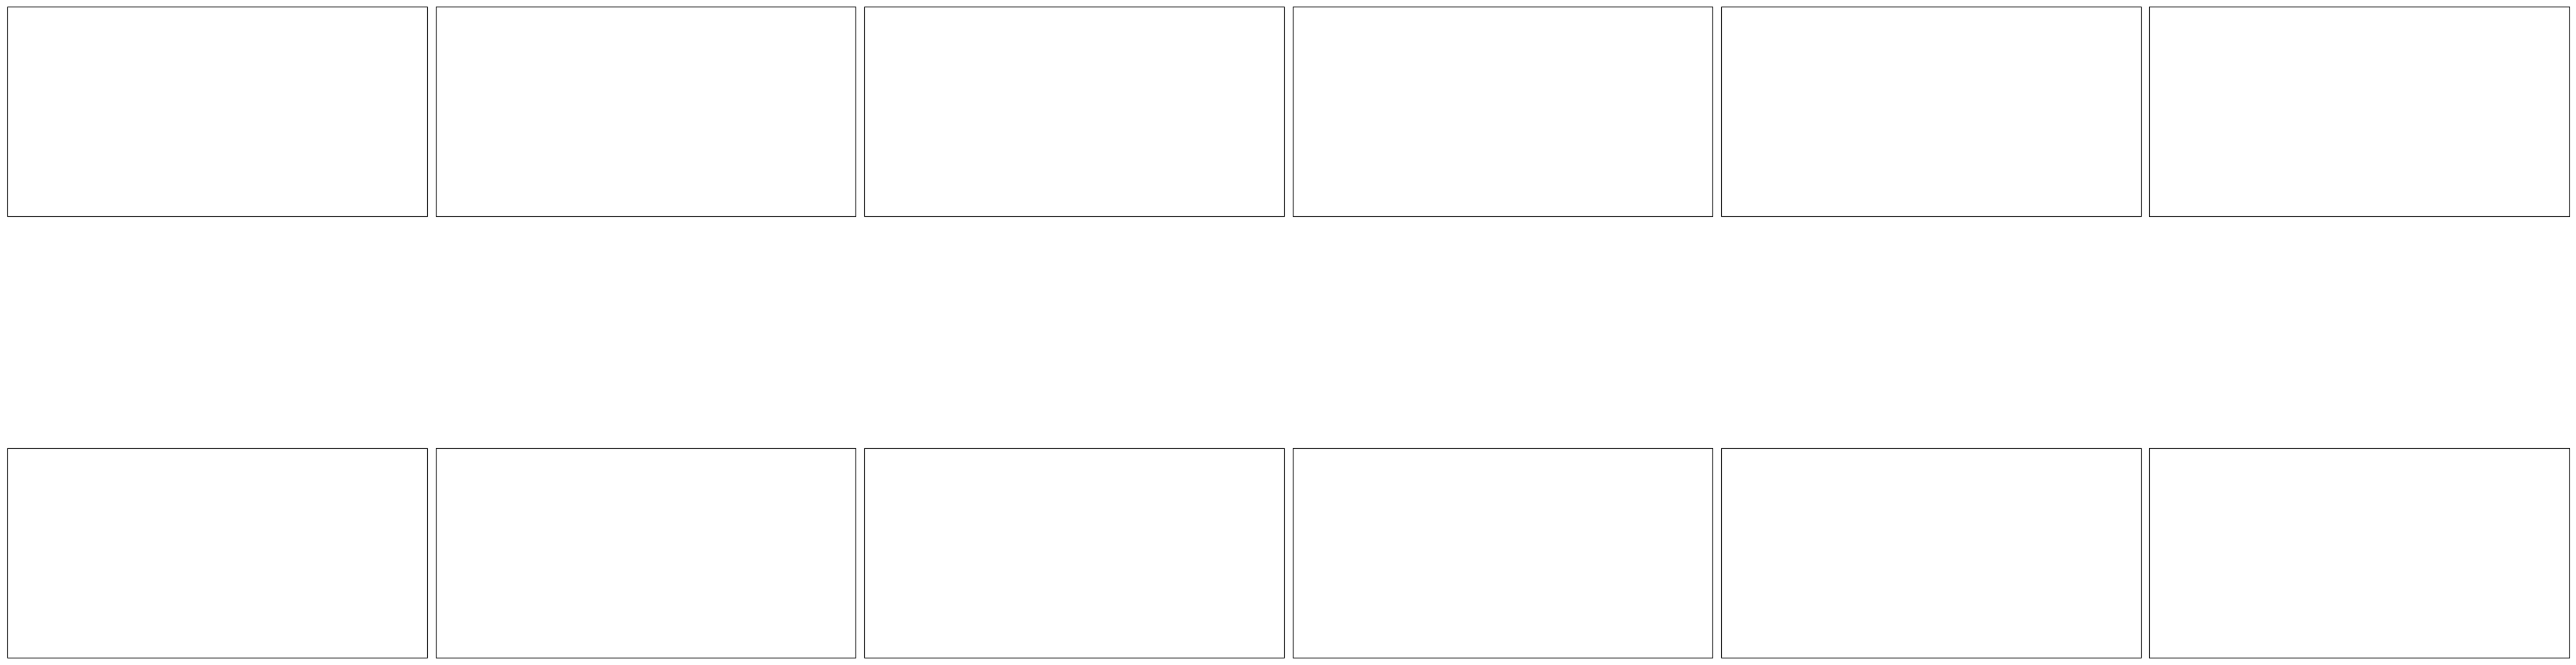

In [22]:
days_row1 = ['0186-07-23', '0186-07-26', '0186-08-12', '0186-08-21', '0186-08-25', '0186-08-31']
days_row2 = ['0187-07-23', '0187-07-26', '0187-08-12', '0187-08-21', '0187-08-25', '0187-08-31']
all_days = days_row1 + days_row2
#0186-08-22
colormap = cm.get_cmap('prism', len(ids))

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(35, 12), subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)

for i, day in enumerate(all_days):
    ax = axes[i]

    sst_full = ds_region.tos.isel(time=ds_region.time.get_index("time").get_loc(day).start)
    s = sst_full.plot(
        ax=ax, cmap="Blues_r", levels=np.arange(26, 29, 0.2), transform=ccrs.PlateCarree(), add_colorbar=False
    )

    mask_day = labels.isel(time=labels.time.get_index("time").get_loc(day).start)

    for idx, id_val in enumerate(ids):
        contour_color = colormap(idx / len(ids))

        event_mask = mask_day.where(mask_day == id_val, drop=False)
        
        if event_mask.notnull().any():
            binary_mask = event_mask.notnull().astype(int)
            binary_mask.plot.contour(
                ax=ax, levels=[0.5], colors=[contour_color],
                linewidths=6, transform=ccrs.PlateCarree()
            )

    mask_filtered = np.isin(mask_day, ids)
    sst_masked = sst_full.where(mask_filtered, drop=False)

    p = sst_masked.plot(
        ax=ax, cmap='Reds', levels=np.arange(29, 32.2, 0.2),
        transform=ccrs.PlateCarree(), add_colorbar=False
    )

    ax.set_xlim(-98, -75)
    ax.set_ylim(18, 32)
    ax.set_title(f"Time: {day}",fontsize=30)
    ax.coastlines(resolution="110m", color='k')

scbar = fig.colorbar(s, ax=axes, orientation='vertical', pad=0.005, shrink=0.4)
scbar.ax.tick_params(labelsize=30)
scbar.set_label('SST [deg C]', fontsize=30)
cbar = fig.colorbar(p, ax=axes, orientation='vertical', pad=0.005, shrink=0.4)
cbar.ax.tick_params(labelsize=30)
cbar.set_label('MHW SST [deg C]', fontsize=30)

#plt.tight_layout()
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/paper/sst-evolution-{days_row1[0]}-{days_row1[-1]}-t1-v3-cT.png', bbox_inches='tight')

plt.show()

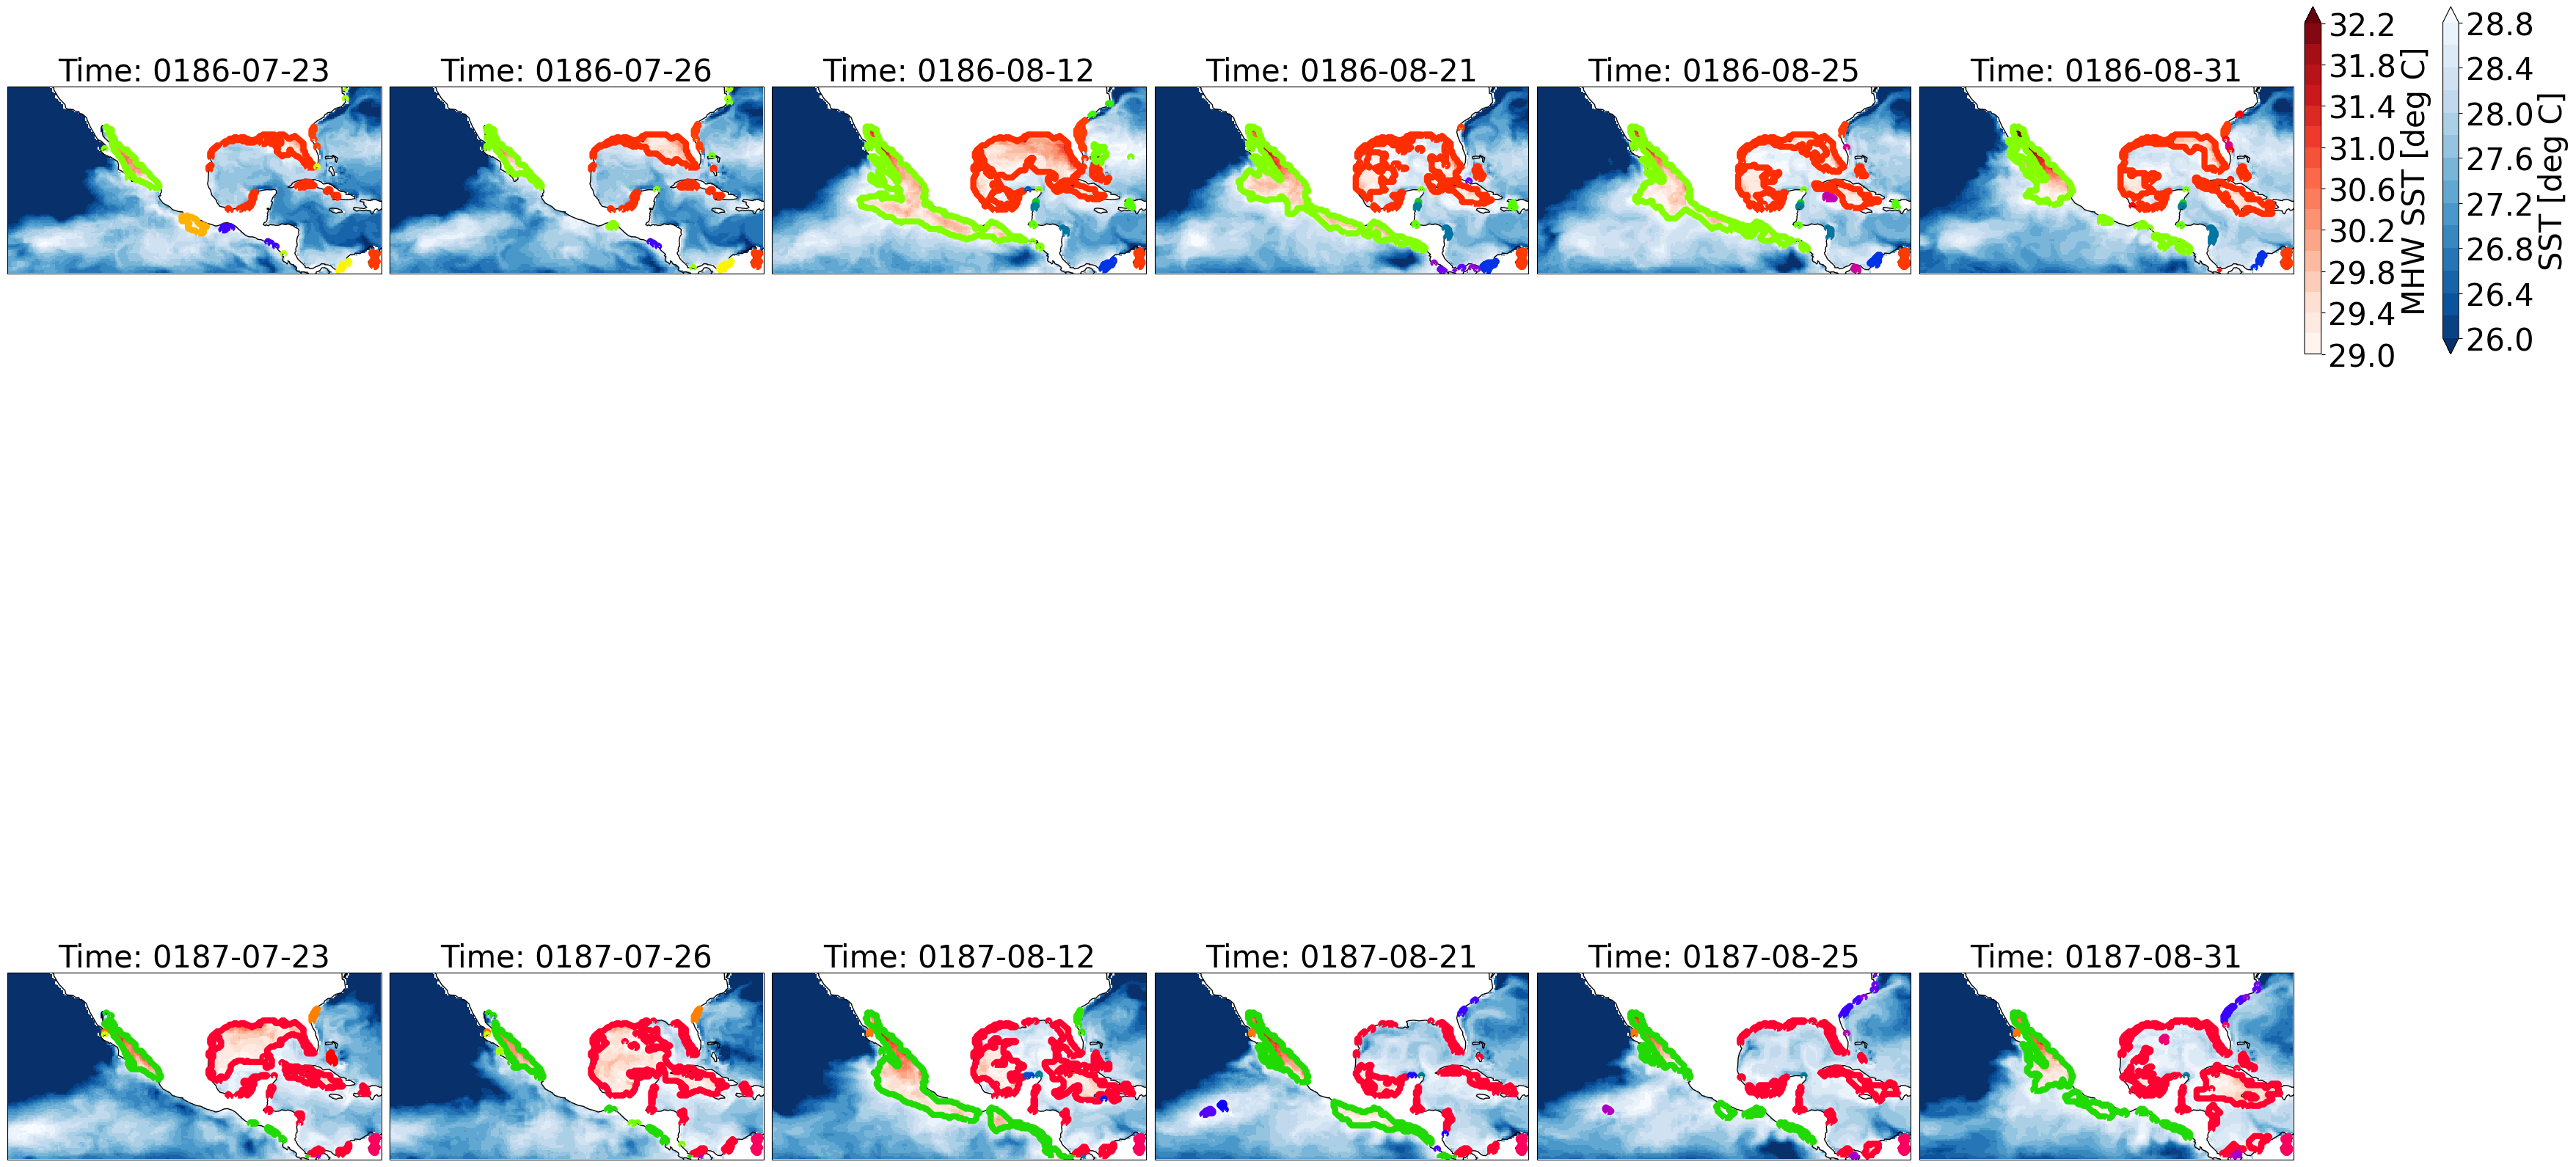

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cartopy.crs as ccrs

# Extend all_days to include multiple years
days_row1 = ['0186-07-23', '0186-07-26', '0186-08-12', '0186-08-21', '0186-08-25', '0186-08-31']
days_row2 = ['0187-07-23', '0187-07-26', '0187-08-12', '0187-08-21', '0187-08-25', '0187-08-31']
all_days = days_row1 + days_row2

# Define colormap
colormap = cm.get_cmap('prism', len(ids))

# Calculate number of rows and columns for subplots
num_plots = len(all_days)
ncols = 6  # Fixed number of columns
nrows = (num_plots + ncols - 1) // ncols  # Calculate rows dynamically

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(35, 12 * nrows), 
                         subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easier indexing

for i, day in enumerate(all_days):
    ax = axes[i]

    # Access the SST data for the specific day
    try:
        sst_full = ds_region.tos.isel(time=ds_region.time.get_index("time").get_loc(day).start)
    except KeyError:
        print(f"Day {day} not found in dataset. Skipping.")
        continue

    s = sst_full.plot(
        ax=ax, cmap="Blues_r", levels=np.arange(26, 29, 0.2), transform=ccrs.PlateCarree(), add_colorbar=False
    )

    mask_day = labels.isel(time=labels.time.get_index("time").get_loc(day).start)

    for idx, id_val in enumerate(ids):
        contour_color = colormap(idx / len(ids))

        event_mask = mask_day.where(mask_day == id_val, drop=False)
        
        if event_mask.notnull().any():
            binary_mask = event_mask.notnull().astype(int)
            binary_mask.plot.contour(
                ax=ax, levels=[0.5], colors=[contour_color],
                linewidths=6, transform=ccrs.PlateCarree()
            )

    mask_filtered = np.isin(mask_day, ids)
    sst_masked = sst_full.where(mask_filtered, drop=False)

    p = sst_masked.plot(
        ax=ax, cmap='Reds', levels=np.arange(29, 32.2, 0.2),
        transform=ccrs.PlateCarree(), add_colorbar=False
    )

    # ax.set_xlim(-98, -75)
    # ax.set_ylim(18, 32)
    ax.set_xlim([-130, -70])
    ax.set_ylim([8, 38])
    ax.set_title(f"Time: {day}", fontsize=30)
    ax.coastlines(resolution="110m", color='k')

# Add colorbars only for the first subplot
scbar = fig.colorbar(s, ax=axes[:ncols], orientation='vertical', pad=0.005, shrink=0.4)
scbar.ax.tick_params(labelsize=30)
scbar.set_label('SST [deg C]', fontsize=30)
cbar = fig.colorbar(p, ax=axes[:ncols], orientation='vertical', pad=0.005, shrink=0.4)
cbar.ax.tick_params(labelsize=30)
cbar.set_label('MHW SST [deg C]', fontsize=30)
# fig.subplots_adjust(hspace=0.3)
#fig.tight_layout(rect=[0, 0.002, 0.845, 1])
# fig.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

In [ ]:
# days_row1 = ['0186-07-23', '0186-07-26', '0186-08-12', '0186-08-21', '0186-08-25', '0186-08-31'] #0186-08-22
# colormap = cm.get_cmap('prism', len(ids))

# fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(35, 12), subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)

# for i, day in enumerate(days_row1):
#     ax = axes[i]

#     sst_full = ds_region.tos.isel(time=ds_region.time.get_index("time").get_loc(day).start)
#     s = sst_full.plot(
#         ax=ax, cmap="Blues_r", levels=np.arange(26, 29, 0.2), transform=ccrs.PlateCarree(), add_colorbar=False
#     )

#     mask_day = labels.isel(time=labels.time.get_index("time").get_loc(day).start)

#     for idx, id_val in enumerate(ids):
#         contour_color = colormap(idx / len(ids))

#         event_mask = mask_day.where(mask_day == id_val, drop=False)
        
#         if event_mask.notnull().any():
#             binary_mask = event_mask.notnull().astype(int)
#             binary_mask.plot.contour(
#                 ax=ax, levels=[0.5], colors=[contour_color],
#                 linewidths=2.5, transform=ccrs.PlateCarree()
#             )

#     mask_filtered = np.isin(mask_day, ids)
#     sst_masked = sst_full.where(mask_filtered, drop=False)

#     p = sst_masked.plot(
#         ax=ax, cmap=cmocean.cm.thermal, levels=np.arange(29, 31.6, 0.2),
#         transform=ccrs.PlateCarree(), add_colorbar=False
#     )

#     ax.set_xlim(-98, -75)
#     ax.set_ylim(18, 32)
#     ax.set_title(f"Time:{day}",fontsize=30)
#     ax.coastlines(resolution="110m", color='k')

# scbar = fig.colorbar(s, ax=axes, orientation='vertical', pad=0.005, shrink=0.4)
# scbar.ax.tick_params(labelsize=30)
# scbar.set_label('SST [deg C]', fontsize=30)
# cbar = fig.colorbar(p, ax=axes, orientation='vertical', pad=0.005, shrink=0.4)
# cbar.ax.tick_params(labelsize=30)
# cbar.set_label('MHW SST [deg C]', fontsize=30)

# #plt.tight_layout()
# #plt.savefig('/pub/mariant3/WarmWaterMasses/figures/paper/ocetrac-output-labels-186-t1-v1-masked-sst-evolution.png', bbox_inches='tight')

# plt.show()